## Task 10.1

Implement the system

$$
    y_k + a y_{k-1} = b u_{k-1} + e_k
$$

where:

- $e_k$ is white Gaussian zero-mean noise with variance $\lambda^2$

- the input is computed through a state-feedback law $u_k = - K y_k + r_k$ with $r_k$ a reference signal

- $K$ is so that the closed loop system in the absence of the reference signal is asymptotically stable, and the mode of the system is non-oscillatory

- $r_k$, for the sake of this assignment, is another white Gaussian zero-mean noise with variance $\sigma^2$


In [2]:
# importing the right packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

np.random.seed(1)

In [3]:
# main function to simulate the system
def simulate( a, b, K, lambda2, sigma2, y0, N, reference_frequency = 0 ):

    # storage allocation
    y = np.zeros(N)
    u = np.zeros(N)

    # saving the initial condition
    y[0] = y0
    
    # system noises
    e = np.random.normal(0, np.sqrt(lambda2),  N)
    r = np.random.normal(0, np.sqrt(sigma2), N) + np.sin( reference_frequency * np.arange(N) )
    
    # cycle on the steps
    for t in range(1, N):
        # on last iteration, when t=N-1, we only set u[N-2] so u[N-1] is always 0.
        u[t-1] = -K*y[t-1] + r[t-1]
        y[t] = -a*y[t-1] + b*u[t-1] + e[t]

    return [y, u]

In [4]:
# define also a function for doing poles allocation, considering
# that eventually if the reference is absent then the ODE is
#
# y_k + ( a + b K ) y_{k-1} = e_k
#

#
# y/e = 1/(1 + (a + b K)*z^-1)
# -> pole = -(a + b K)
#
# -a - b K = pole
# -b K = pole + a
# K = (pole + a) / (-b)
#
# Gain K = -(pole + a) / b
#
def compute_gain( a, b, desired_pole_location ):
    return -(desired_pole_location + a) / b

In [5]:
# plotting of the impulse response
def plot_impulse_response( a, b, figure_number = 1000 ):
    
    # ancillary quantities
    k = range(0,50)
    y = b * np.power( -a, k )
    
    # plotting the various things
    plt.figure( figure_number )
    plt.plot(y, 'r-', label = 'u')
    plt.xlabel('time')
    plt.ylabel('impulse response relative to a = {} and b = {}'.format(a, b))

In [6]:
# define the system parameters
a = -0.5
b = 2
K = compute_gain( a, b, 0.7 )

# noises
lambda2 = 0.1 # on e
sigma2  = 0.1 # on r

# initial condition
y0 = 3

# number of steps
N = 100

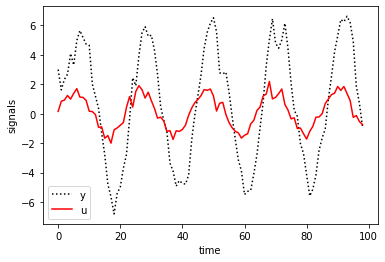

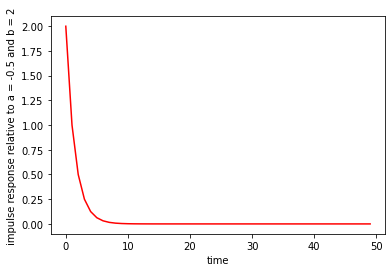

In [7]:
# DEBUG - check that things work as expected

# run the system
[y, u] = simulate( a, b, K, lambda2, sigma2, y0, N, 0.3 )

# plotting the various things
plt.figure()
plt.plot(y[:-1], 'k:', label = 'y')
plt.plot(u[:-1], 'r-', label = 'u')
plt.xlabel('time')
plt.ylabel('signals')
plt.legend()

plot_impulse_response( a, b )

## Task 10.2

Implement a PEM-based approach to the estimation of the system, assuming to know the correct model structure but not knowing about the existence of the feedback loop given by $K$.

In [8]:
# important: the system is an ARX one, and e_k is Gaussian so PEM = ???
# And given this, how can we simplify things?

In [9]:
# define the function solving the PEM problem asked in the assignment

"""
https://www.it.uu.se/edu/course/homepage/systemid/vt12/ch6.pdf

theta = [a1, ..., aN, b1, ..., bN]
y_hat[k] = -a1*y[k-1] - ... - aN*y[k-N] + b1*u[k-1] + ... + bN*u[k-N] = phi.T @ theta
phi = [ -y[k-1], ..., -y[k-N], u[k-1], ..., u[k-N] ]

theta_hat = arg min ( y[k] - y_hat[k](theta) )^2 
"""
def PEM_solver( u, y ):
    # y = [ y[0], y[1], y[2], ..., y[t-1], y[t] ]
    # u = [ u[0], u[1], ..., u[t-2], u[t-1], u[t]=0 ] ,  u[t] is never set and must be ignored
    phi = np.array([ -y[-2], u[-2] ]).reshape((-1, 1))
    
    # compute the PEM estimate by directly solving the normal equations
    theta_hat = np.linalg.solve( phi.T @ phi, phi.T * y[-2] ).ravel()

    # explicit the results
    a_hat = theta_hat[0]
    b_hat = theta_hat[1]

    return [a_hat, b_hat]

In [10]:
# compute the solution
[a_hat, b_hat] = PEM_solver( u, y )

# assess the performance
MSE = np.linalg.norm([a - a_hat, b - b_hat])**2

# print debug info
print('MSE: {}'.format(MSE))
print('a, b = {}, {}   --    ahat, bhat = {}, {}'.format(a, b, a_hat, b_hat))

MSE: 2.293863894155823
a, b = -0.5, 2   --    ahat, bhat = -0.6041427912209901, 0.48903402646104427


## Task 10.3

Show from a numerical perspective that for $\lambda^2 = 0.1$ (i.e., a constant variance on the process noise) the estimates are consistent.

In [11]:
# the best way to show this is to do a Monte Carlo approach:
# - for each N, compute the distribution of the estimates
#   around the true parameters
# - increase N and show that this distribution tends to
#   converge to the true parameters

# defining the MC simulation
N_MC_runs       = 100
min_order_for_N = 1
max_order_for_N = 4
num_of_N_orders = max_order_for_N - min_order_for_N + 1;

# noises and initial condition
lambda2 = 0.1 # on e
sigma2  = 0.1 # on r
y0      = 0

# storage allocation
MSEs = np.zeros( (num_of_N_orders, N_MC_runs) )
theta_hats = np.zeros( (num_of_N_orders, N_MC_runs, 2) )

# cycle on the number of samples
for j, N in enumerate( np.logspace( min_order_for_N, max_order_for_N, num_of_N_orders ) ):
    N = int(N)

    # debug
    print('starting computing order {} of {}'.format(j+1, num_of_N_orders))
    
    # MC cycles
    for m in range(N_MC_runs):
    
        # simulate the system
        [y, u] = simulate( a, b, K, lambda2, sigma2, y0, N, 0.3 )

        # compute the solution
        [a_hat, b_hat] = PEM_solver(u, y)

        # assess the performance
        MSEs[j, m] = np.linalg.norm([a - a_hat, b - b_hat])**2
        
        # save the results
        theta_hats[j, m, 0] = a_hat
        theta_hats[j, m, 1] = b_hat

starting computing order 1 of 4
starting computing order 2 of 4
starting computing order 3 of 4
starting computing order 4 of 4


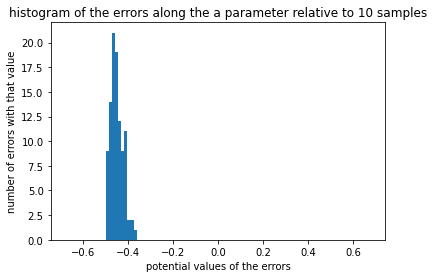

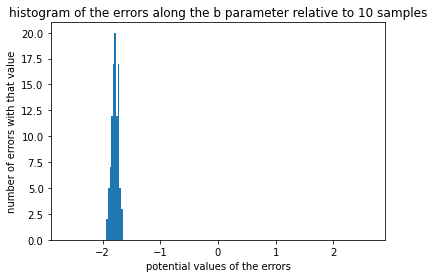

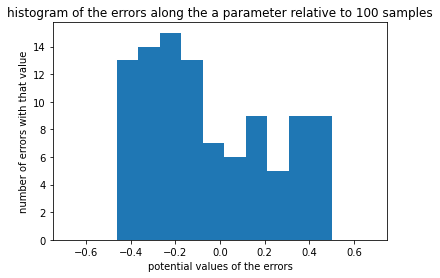

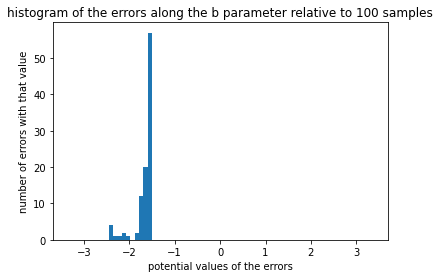

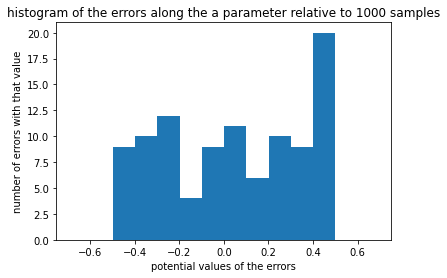

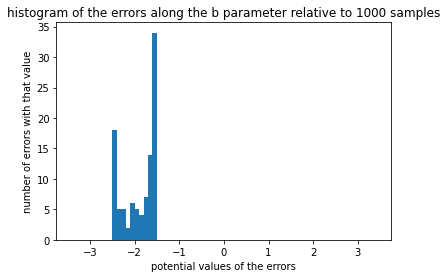

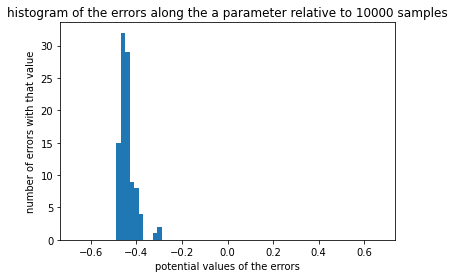

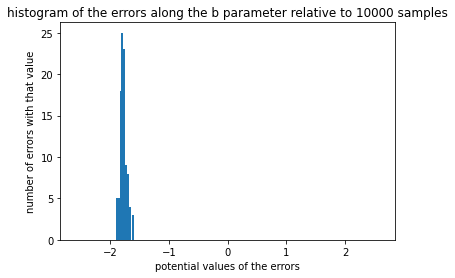

In [12]:
# cycle on the number of samples
for j, N in enumerate( np.logspace( min_order_for_N, max_order_for_N, num_of_N_orders ) ):
    N = int(N)
    
    # plot the histogram of the MSEs relative to this number of samples
    # plt.figure(j)
    # plt.hist(MSEs[j,:])
    # plt.xlim(0, 1.5 * np.max(MSEs[j,:]))
    # plt.title('histogram of the MSEs relative to {} samples'.format(N))
    # plt.xlabel('potential values of the MSE')
    # plt.ylabel('number of MSEs with that value')

    # plot the histogram of the errors along the a parameter
    plt.figure(j + 100)
    x_lim = np.max(np.abs(theta_hats[j,:,0] - a))
    plt.hist(theta_hats[j,:,0] - a)
    plt.xlim(-1.5 * x_lim, 1.5 * x_lim)
    plt.title('histogram of the errors along the a parameter relative to {} samples'.format(N))
    plt.xlabel('potential values of the errors')
    plt.ylabel('number of errors with that value')

    # plot the histogram of the errors along the b parameter
    plt.figure(j + 200)
    x_lim = np.max(np.abs(theta_hats[j,:,1] - b))
    plt.hist(theta_hats[j,:,1] - b)
    plt.xlim(-1.5 * x_lim, 1.5 * x_lim)
    plt.title('histogram of the errors along the b parameter relative to {} samples'.format(N))
    plt.xlabel('potential values of the errors')
    plt.ylabel('number of errors with that value')

We see as N increases, the distribution becomes smaller, thus showing that the estimates are consistent. 


PEM tries to solve for a and b assuming this model:

    y[k] = -a y[k-1] + b u[k-1]


Our (closed-loop) model is actually:

    y[k] = -(a + b K) y[k-1] + 0 u[k-1]

Hence, the estimates should converge towards

    a_hat --> a + b K = -0.5 + 2 * -0.1 = -0.7
    b_hat --> 0

The plot showing a error converges to between -0.4 and -0.5, while the plot for b error converges to around -1.8. Since a = -0.5, b = 2, and K = -0.1, the estimates are close to what we would expect them to converge to. 



## Task 10.3

Show that the variances of the estimates though will tend to infinity as $\sigma^2 \rightarrow 0$, i.e., the reference becomes a deterministic known signal.

In [13]:
# again the best way to show this is to do a Monte Carlo approach:
# - for each sigma2, compute the distribution of the estimates
#   around the true parameters
# - diminish sigma2 and show that this distribution tends to
#   diverge

# defining the MC simulation
N                    = 100
N_MC_runs            = 100
min_order_for_sigma2 = -3
max_order_for_sigma2 = 1
num_of_sigma2_orders = max_order_for_sigma2 - min_order_for_sigma2 + 1;

# noises and initial condition
lambda2 = 0.1 # on e
y0      = 0

# storage allocation
MSEs = np.zeros( (num_of_sigma2_orders, N_MC_runs) )
theta_hats = np.zeros( (num_of_sigma2_orders, N_MC_runs, 2) )

# cycle on the variance of the measurement noise
for j, sigma2 in enumerate( np.logspace( min_order_for_sigma2, max_order_for_sigma2, num_of_sigma2_orders ) ):

    # debug
    print('starting computing order {} of {}'.format(j+1, num_of_sigma2_orders))
    
    # MC cycles
    for m in range(N_MC_runs):
    
        # simulate the system
        [y, u] = simulate( a, b, K, lambda2, sigma2, y0, N, 0.3 )

        # compute the solution
        [a_hat, b_hat] = PEM_solver(u, y)

        # assess the performance
        MSEs[j,m] = np.linalg.norm([a - a_hat, b - b_hat])**2
        
        # save the results
        theta_hats[j,m,0] = a_hat
        theta_hats[j,m,1] = b_hat

starting computing order 1 of 5
starting computing order 2 of 5
starting computing order 3 of 5
starting computing order 4 of 5
starting computing order 5 of 5


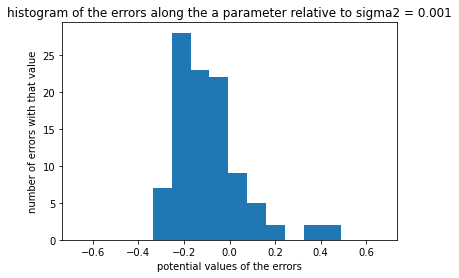

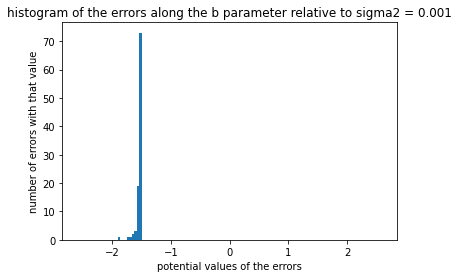

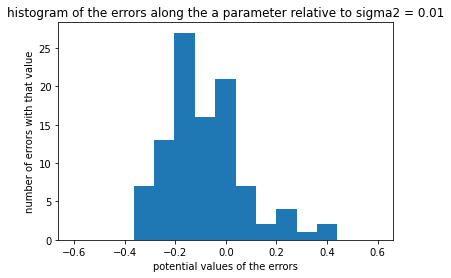

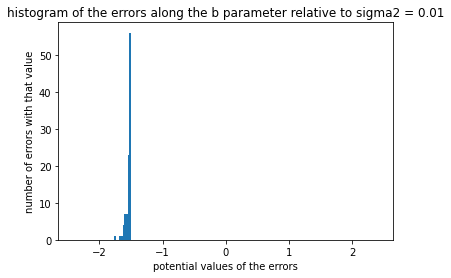

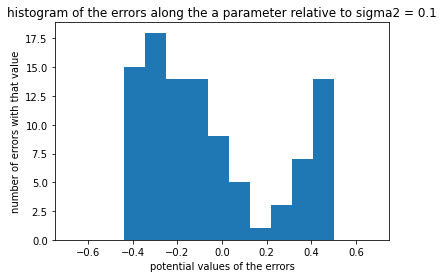

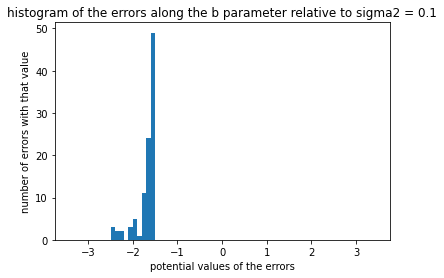

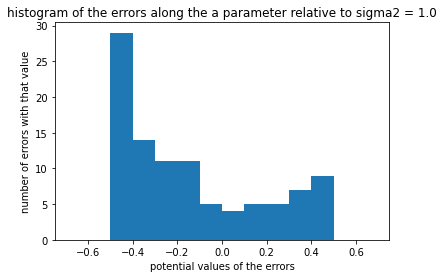

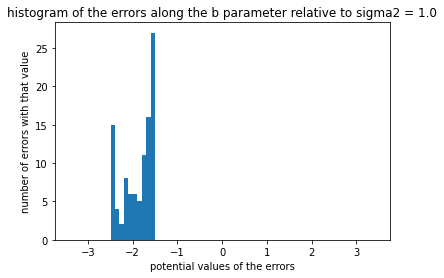

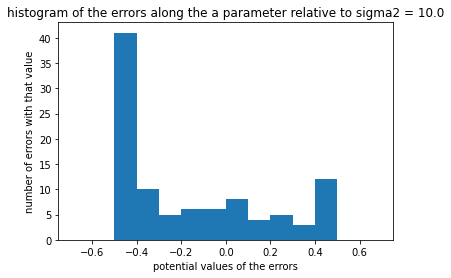

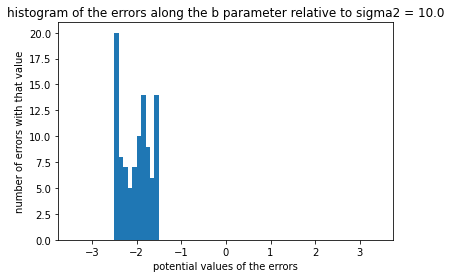

In [14]:
# cycle on the variance of the measurement noise
for j, sigma2 in enumerate( np.logspace( min_order_for_sigma2, max_order_for_sigma2, num_of_sigma2_orders ) ):
    
    # plot the histogram of the MSEs relative to this number of samples
    # plt.figure(j)
    # plt.hist(MSEs[j,:])
    # plt.xlim(0, 1.5 * np.max(MSEs[j,:]))
    # plt.title('histogram of the MSEs relative to sigma2 = {}'.format(sigma2))
    # plt.xlabel('potential values of the MSE')
    # plt.ylabel('number of MSEs with that value')
    
    # plot the histogram of the errors along the a parameter
    plt.figure(j + 100)
    x_lim = np.max(np.abs(theta_hats[j,:,0] - a))
    plt.hist(theta_hats[j,:,0] - a)
    plt.xlim(-1.5 * x_lim, 1.5 * x_lim)
    plt.title('histogram of the errors along the a parameter relative to sigma2 = {}'.format(sigma2))
    plt.xlabel('potential values of the errors')
    plt.ylabel('number of errors with that value')

    # plot the histogram of the errors along the b parameter
    plt.figure(j + 200)
    x_lim = np.max(np.abs(theta_hats[j,:,1] - b))
    plt.hist(theta_hats[j,:,1] - b)
    plt.xlim(-1.5 * x_lim, 1.5 * x_lim)
    plt.title('histogram of the errors along the b parameter relative to sigma2 = {}'.format(sigma2))
    plt.xlabel('potential values of the errors')
    plt.ylabel('number of errors with that value')


## Task 10.4

It is weird that the expected behavior with increasing variance is not seen...